## Please complete before submission:

**Name:** SRISHTI BHAT

**Student Number:** 2582332B

# TextAs Data Coursework

Please fill in this Google Colab by following the prompts from the coursework specification document and inserting your code in each relevant section.

- You should submit this notebook together with your report. (Two separate files)
- Specifcally you will submit **both a PDF with the report (so we can easily read it) and a .ipynb file containing the source code of your experiments as evidence**. Please do clean up your code where possible before submitting it.
- You may add whatever additional code and text blocks as needed (perhaps with [nice formatting](https://colab.research.google.com/notebooks/markdown_guide.ipynb)). Please keep the major headings (for the question numbers) the same.

As with labs, please remember to **Save a Copy to Drive** when you start working on this so that it is saved. Completing the labs provides essential knowledge for the successful completion of the coursework. 

## Downloading and loading Data

This code loads the prepared split of the Reddit data into training, validation and testing set.

In [166]:
!wget -O reddit_data_split.zip https://gla-my.sharepoint.com/:u:/g/personal/jake_lever_glasgow_ac_uk/EapVNOIV84tPnQuuFBNgG9UBYIWipQ9JL4QTfSgRtIacBw?download=1
!unzip -o reddit_data_split.zip

--2022-03-26 22:54:21--  https://gla-my.sharepoint.com/:u:/g/personal/jake_lever_glasgow_ac_uk/EapVNOIV84tPnQuuFBNgG9UBYIWipQ9JL4QTfSgRtIacBw?download=1
Resolving gla-my.sharepoint.com (gla-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to gla-my.sharepoint.com (gla-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/jake_lever_glasgow_ac_uk/Documents/Teaching/reddit_data_split.zip [following]
--2022-03-26 22:54:23--  https://gla-my.sharepoint.com/personal/jake_lever_glasgow_ac_uk/Documents/Teaching/reddit_data_split.zip
Reusing existing connection to gla-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 468327 (457K) [application/x-zip-compressed]
Saving to: ‘reddit_data_split.zip’

reddit_data_split.z 100%[===================>] 457.35K   409KB/s    in 1.1s    

2022-03-26 22:54:24 (409 KB/s) - ‘reddit_data_split.zip’ saved [468327/468327]

Archive:  reddit_data_split.zip
  in

Downloaded Data is divided into 3 sets of data
1. Train Dataset
2. Test Dataset
3. Validation Dataset

In [167]:
import json

with open('reddit_train.json') as f:
    train_data = json.load(f)
with open('reddit_val.json') as f:
    validation_data = json.load(f)
with open('reddit_test.json') as f:
    test_data = json.load(f)

print("Number of posts in training data:", len(train_data))
print("Number of posts in validation data:", len(validation_data))
print("Number of posts in test data:", len(test_data))

Number of posts in training data: 1200
Number of posts in validation data: 400
Number of posts in test data: 400


##  Importing Required Packages


In [168]:
#!pip install -U spacy
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
import requests
import time
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus.reader.knbc import test
import pandas as pd

# Load the medium english model. 
# We will use this model to get embedding features for tokens later.
#!python -m spacy download en_core_web_md

nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis

### Cleaning/Pre-processing Data

In [169]:

#Respective dataframes are created for each dataset
train_data = pd.DataFrame(train_data)
validation_data = pd.DataFrame(validation_data)
test_data = pd.DataFrame(test_data)

#removed duplicate titles
train_data.drop_duplicates(subset='title', inplace = True)
validation_data.drop_duplicates(subset='title', inplace = True)
test_data.drop_duplicates(subset='title', inplace = True)

# Check for the Null Entries
print("Train - Null Entries:")
print(train_data.isnull().sum())
print("Validation - Null Entries:")
print(validation_data.isnull().sum())
print("Test - Null Entries:")
print(test_data.isnull().sum())

Train - Null Entries:
subreddit    0
title        0
score        0
id           0
author       0
body         0
dtype: int64
Validation - Null Entries:
subreddit    0
title        0
score        0
id           0
author       0
body         0
dtype: int64
Test - Null Entries:
subreddit    0
title        0
score        0
id           0
author       0
body         0
dtype: int64


### Printing first few rows of the train dataset

In [170]:
train_data.head()

,subreddit,title,score,id,author,body
0,PS4,Can I get banned for having a game that I didn...,0,queqfu,XC-XERZ,"Long story short, I saw ESO in my library, dow..."
1,pcgaming,How to get a Kinect sensor to work with a PC?,0,1eujoa,ZachTheKing,I have seen a video online where someone took ...
2,NintendoSwitch,Switch Only Charges with GoPro Cable,5,m00bx7,BluePenguin2002,"Hi, hope this is the right place/way to post t..."
3,antiMLM,L’Occitane going down MLM route?,15,q13pvx,100fluffyclouds,After buying a majority share in Limelight/Alc...
4,HydroHomies,Guys i need your help,2,rxiv2g,Epicskeleton53,Is it ok for me to drink coffee in the morning...


### Histogram of train Dataset

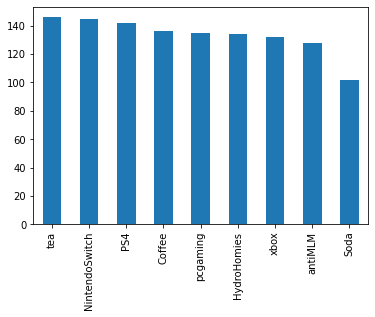

In [171]:
train_data['subreddit'].value_counts().plot.bar()

### Histogram of Test Dataset

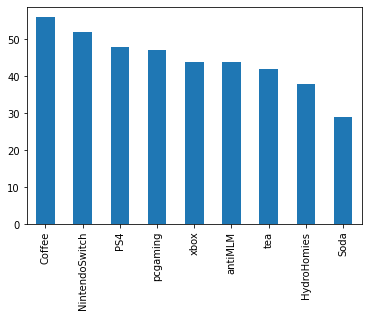

In [172]:
test_data['subreddit'].value_counts().plot.bar()

### Histogram of Validation Dataset

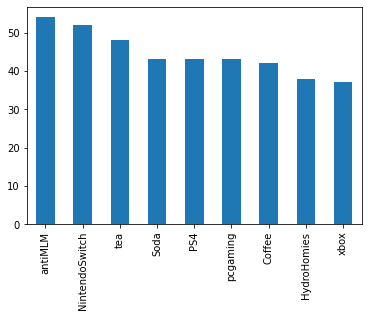

In [173]:
validation_data['subreddit'].value_counts().plot.bar()

### Mapping unique numbers to each subreddit label

In [174]:
unique_labels = train_data.subreddit.unique()
print(unique_labels)
unique_labels_dict = {}
unique_labels_rev_dict = {}

for i,l in enumerate(unique_labels):
  unique_labels_dict[l] = i
  unique_labels_rev_dict[i] = l
print(unique_labels_dict)
print(unique_labels_rev_dict)

['PS4' 'pcgaming' 'NintendoSwitch' 'antiMLM' 'HydroHomies' 'Coffee' 'xbox'
 'Soda' 'tea']
{'PS4': 0, 'pcgaming': 1, 'NintendoSwitch': 2, 'antiMLM': 3, 'HydroHomies': 4, 'Coffee': 5, 'xbox': 6, 'Soda': 7, 'tea': 8}
{0: 'PS4', 1: 'pcgaming', 2: 'NintendoSwitch', 3: 'antiMLM', 4: 'HydroHomies', 5: 'Coffee', 6: 'xbox', 7: 'Soda', 8: 'tea'}


In [175]:
train_data['labels'] = train_data['subreddit'].map(unique_labels_dict)
validation_data['labels'] = validation_data['subreddit'].map(unique_labels_dict)
test_data['labels'] = test_data['subreddit'].map(unique_labels_dict)

#train_data

In [176]:
train_data

,subreddit,title,score,id,author,body,labels
0,PS4,Can I get banned for having a game that I didn...,0,queqfu,XC-XERZ,"Long story short, I saw ESO in my library, dow...",0
1,pcgaming,How to get a Kinect sensor to work with a PC?,0,1eujoa,ZachTheKing,I have seen a video online where someone took ...,1
2,NintendoSwitch,Switch Only Charges with GoPro Cable,5,m00bx7,BluePenguin2002,"Hi, hope this is the right place/way to post t...",2
3,antiMLM,L’Occitane going down MLM route?,15,q13pvx,100fluffyclouds,After buying a majority share in Limelight/Alc...,3
4,HydroHomies,Guys i need your help,2,rxiv2g,Epicskeleton53,Is it ok for me to drink coffee in the morning...,4
...,...,...,...,...,...,...,...
1195,xbox,I’m debating if I should get a PC or Xbox Seri...,2,m6a172,Matt3339,I do have some question as well.\n1. Can the S...,6
1196,Coffee,Where can I buy several exotic or unique coffees?,10,3yvspn,victorlinguist,I am looking for an online place that will off...,5
1197,tea,What are some of y'all's favorite non-caffeina...,5,bdlfo5,Bobthebanana73,"Due to medical reasons, I am currently not all...",8
1198,Coffee,[Q] What pour over method should I try?,7,htwdo3,NorwegianWarlord,Hey all!\nThe recent years I've learned to lov...,5


### Splitting Train, Test and Validation datasets to X and Y

Here X would be body, and Y would be the subreddit we are trying to predict/classify

In [177]:
X_train = train_data['body']
Y_train = train_data['labels']

X_val = validation_data['body']
Y_val = validation_data['labels']

X_test = test_data['body']
Y_test = test_data['labels']

### A function to Tokenize text

In [178]:
def text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space and t.lemma_.isalnum():
            tokens.append(t.lemma_.lower())
    tokens = ' '.join([char for char in tokens])
    return tokens


The posts in each subreddit is tokenized

In [179]:
X_train_tokenized = [ text_pipeline_spacy(x) for x in X_train ]
X_train_tokenized[0:5]

['long story short see eso library download let play think free trial go sure buy game',
 'see video online take kinect control character garry mod love know like game pc kinect sensor work',
 'hi hope right place way post try use portable 12w 5v mu charger charge switch work great charge switch play quickly sleep mode work gopro usb c cable nintendo pro controller usb c cable purchase anker barely provide power wall adapter barely charge switch sleep mode discharge normal rate play idea case gopro cable short inconvenient play charge want find long cable charge switch properly thank help',
 'buy majority share limelight alcone go mlm route scroll news item',
 'okay drink coffee morning drink good water okay']

## Q1:

Use the text from the reddit posts (known as “body”) to train classification models using the Scikit Learn package. The labels to predict are the subreddit for each post. Conduct experiments using the following combinations of classifier models and feature representations:
1. Dummy Classifier with strategy="most_frequent"
2. Dummy Classifier with strategy="stratified"
3. LogisticRegression with One-hot vectorization 
4. LogisticRegression with TF-IDF vectorization (default settings)
5. SVC Classifier with  One-hot vectorization (SVM with RBF kernel, default settings))


### Importing Required Packages

In [180]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Transforming given text to Vectors based on the count of each word that occurs in the entire text

In [181]:
OH_transformer = CountVectorizer() #creates vectors on the basis of frequency of the occurence term
OH_transformer.fit(X_train_tokenized)

OHV_train = OH_transformer.transform(X_train)
OHV_test = OH_transformer.transform(X_test)
OHV_valid = OH_transformer.transform(X_val)

### Transforming given text to Vectors based on the TF-IDF weights

In [182]:
tfidf_transformer = TfidfVectorizer() #creates vectors on the basis of TF-IDF
tfidf_transformer.fit(X_train_tokenized)

tfidf_vec_train = tfidf_transformer.transform(X_train)
tfidf_vec_test = tfidf_transformer.transform(X_test)
tfidf_vec_valid = tfidf_transformer.transform(X_val)

### Q1a:
An important first step for any machine learning project is to explore the dataset. Calculate counts for the various
labels and comment on the distribution of labels in the training/validation/test sets

### Count of posts per subreddit for different datasets

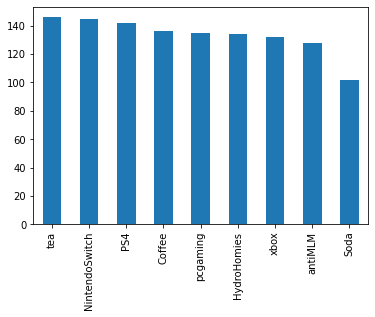

In [183]:
train_data['subreddit'].value_counts().plot.bar()

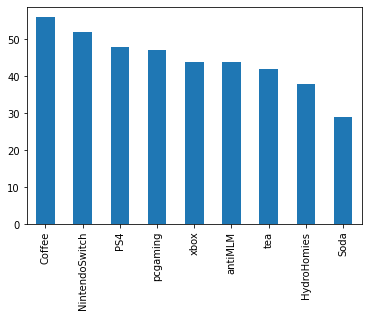

In [184]:
test_data['subreddit'].value_counts().plot.bar()

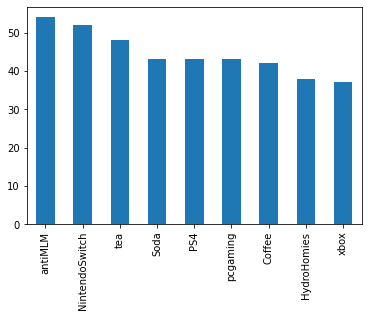

In [185]:
validation_data['subreddit'].value_counts().plot.bar()

In [186]:
train_data
subreddit = train_data.subreddit.unique().tolist()
df_subr = train_data['subreddit'].value_counts()
df_subr.to_frame()
df_subr

tea               146
NintendoSwitch    145
PS4               142
Coffee            136
pcgaming          135
HydroHomies       134
xbox              132
antiMLM           128
Soda              102
Name: subreddit, dtype: int64

In [187]:
test_data
subreddit = test_data.subreddit.unique().tolist()
df_subr_t = test_data['subreddit'].value_counts()
df_subr_t.to_frame()
df_subr_t

Coffee            56
NintendoSwitch    52
PS4               48
pcgaming          47
xbox              44
antiMLM           44
tea               42
HydroHomies       38
Soda              29
Name: subreddit, dtype: int64

In [188]:
subreddit = validation_data.subreddit.unique().tolist()
df_subr_v = validation_data['subreddit'].value_counts()
df_subr_v.to_frame()
df_subr_v

antiMLM           54
NintendoSwitch    52
tea               48
Soda              43
PS4               43
pcgaming          43
Coffee            42
HydroHomies       38
xbox              37
Name: subreddit, dtype: int64

### Q1b:
Implement the five classifiers above, train them on the training set and evaluate on the test set. Discuss the classifier performance in comparison to the others and preprocessing techniques.

For the above classifiers report the classifier accuracy as well as macro/weighted-averaged precision, recall, and F1 (to three decimal places). Show the overall results  obtained by the classifiers on the training and test sets in one table, and highlight the best performance. For the best performing classifier (by weighted F1 in test set) Include a bar chart graph with the F1 score for each class - (subreddits on x-axis, F1 score on Y axis).
Analyse and discuss the effectiveness of the classifiers. Your discussion should include how the models perform relative to the baselines and each other. It should discuss the classifiers’ behaviours with respect to: 
1. Appropriate model “fit” (how well is the model fit to the training/test dataset),
2. Dataset considerations (e.g. how are labels distributed, any other dataset issues?)
3. Classifier models (and their key parameters).


In [189]:
classifier_scores = pd.DataFrame(columns=['classifier', 'accuracy', 'precision', 'recall', 'f1_score'])

## Dummy Classifier 

with  strategy most_frequent

In [190]:
dummy_mf_model = DummyClassifier(strategy='most_frequent')
dummy_mf_model.fit(OHV_train, Y_train)
preds = dummy_mf_model.predict(OHV_test)
print(classification_report(Y_test, preds))


classifier_scores = classifier_scores.append({'classifier' : 'Dummy_classifier_Most_frequent',
                          'accuracy' : accuracy_score(Y_test, preds),
                          'precision' : precision_score(Y_test, preds, average='weighted'),
                          'recall' : recall_score(Y_test, preds, average='weighted'),
                          'f1_score' : f1_score(Y_test, preds, average='weighted')}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.00      0.00      0.00        47
           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00        44
           4       0.00      0.00      0.00        38
           5       0.00      0.00      0.00        56
           6       0.00      0.00      0.00        44
           7       0.00      0.00      0.00        29
           8       0.10      1.00      0.19        42

    accuracy                           0.10       400
   macro avg       0.01      0.11      0.02       400
weighted avg       0.01      0.10      0.02       400



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

## Dummy Classifier 

with  strategy stratified

In [191]:
dummy_mf_model = DummyClassifier(strategy='stratified')
dummy_mf_model.fit(OHV_train, Y_train)
preds = dummy_mf_model.predict(OHV_test)
print(classification_report(Y_test, preds))

classifier_scores = classifier_scores.append({'classifier' : 'Dummy_classifier_stratified',
                          'accuracy' : accuracy_score(Y_test, preds),
                          'precision' : precision_score(Y_test, preds, average='weighted'),
                          'recall' : recall_score(Y_test, preds, average='weighted'),
                          'f1_score' : f1_score(Y_test, preds, average='weighted')}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.15      0.17      0.16        48
           1       0.19      0.17      0.18        47
           2       0.08      0.08      0.08        52
           3       0.13      0.16      0.15        44
           4       0.12      0.18      0.15        38
           5       0.10      0.05      0.07        56
           6       0.16      0.16      0.16        44
           7       0.05      0.03      0.04        29
           8       0.13      0.17      0.15        42

    accuracy                           0.13       400
   macro avg       0.12      0.13      0.13       400
weighted avg       0.13      0.13      0.13       400



## Logistic Regression

with one-hot Vectorization

In [192]:
lr_model_OHV = LogisticRegression(max_iter = 1000)
lr_model_OHV.fit(OHV_train, Y_train)
preds = lr_model_OHV.predict(OHV_test)
print(classification_report(Y_test, preds))

classifier_scores = classifier_scores.append({'classifier' : 'LogisticRegression - One Hot Vector',
                          'accuracy' : accuracy_score(Y_test, preds),
                          'precision' : precision_score(Y_test, preds, average='weighted'),
                          'recall' : recall_score(Y_test, preds, average='weighted'),
                          'f1_score' : f1_score(Y_test, preds, average='weighted')}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.52      0.65      0.57        48
           1       0.66      0.57      0.61        47
           2       0.82      0.71      0.76        52
           3       0.83      0.68      0.75        44
           4       0.79      0.89      0.84        38
           5       0.79      0.80      0.80        56
           6       0.73      0.68      0.71        44
           7       0.65      0.83      0.73        29
           8       0.93      0.88      0.90        42

    accuracy                           0.74       400
   macro avg       0.75      0.74      0.74       400
weighted avg       0.75      0.74      0.74       400



## Logistic Regression

with TF-IDF Vectorization

In [193]:
lr_model_tfidf = LogisticRegression(max_iter = 1000)
lr_model_tfidf.fit(tfidf_vec_train, Y_train)
preds = lr_model_tfidf.predict(tfidf_vec_test)
report_lr = classification_report(Y_test, preds, output_dict = True)
print(classification_report(Y_test, preds))

classifier_scores = classifier_scores.append({'classifier' : 'LogisticRegression - TFIDF',
                          'accuracy' : accuracy_score(Y_test, preds),
                          'precision' : precision_score(Y_test, preds, average='weighted'),
                          'recall' : recall_score(Y_test, preds, average='weighted'),
                          'f1_score' : f1_score(Y_test, preds, average='weighted')}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.53      0.56      0.55        48
           1       0.60      0.55      0.58        47
           2       0.66      0.73      0.69        52
           3       0.67      0.84      0.75        44
           4       0.83      0.79      0.81        38
           5       0.86      0.88      0.87        56
           6       0.70      0.59      0.64        44
           7       0.80      0.69      0.74        29
           8       0.97      0.88      0.93        42

    accuracy                           0.73       400
   macro avg       0.74      0.72      0.73       400
weighted avg       0.73      0.72      0.73       400



## SVC Classifier 

with  One-hot vectorization 

In [194]:
svc_tfidf_model = SVC(kernel='rbf')
svc_tfidf_model.fit(OHV_train, Y_train)
preds = svc_tfidf_model.predict(OHV_test)
print(classification_report(Y_test, preds))

classifier_scores = classifier_scores.append({'classifier' : 'SVC(rbf)',
                          'accuracy' : accuracy_score(Y_test, preds),
                          'precision' : precision_score(Y_test, preds, average='weighted'),
                          'recall' : recall_score(Y_test, preds, average='weighted'),
                          'f1_score' : f1_score(Y_test, preds, average='weighted')}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.28      0.69      0.40        48
           1       0.60      0.26      0.36        47
           2       0.70      0.73      0.72        52
           3       0.58      0.57      0.57        44
           4       0.91      0.79      0.85        38
           5       0.93      0.71      0.81        56
           6       0.80      0.45      0.58        44
           7       0.65      0.69      0.67        29
           8       0.97      0.79      0.87        42

    accuracy                           0.63       400
   macro avg       0.71      0.63      0.65       400
weighted avg       0.71      0.63      0.64       400



### Comparison of performance of all models 

In [195]:
def highlight_max(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: yellow'if is_max.any() else''for v in is_max]

classifier_scores.style.apply(highlight_max, threshold=classifier_scores['f1_score'].max(), column=['f1_score'], axis=1)

,classifier,accuracy,precision,recall,f1_score
0,Dummy_classifier_Most_frequent,0.105000,0.011025,0.105000,0.019955
1,Dummy_classifier_stratified,0.130000,0.126524,0.130000,0.126329
2,LogisticRegression - One Hot Vector,0.737500,0.748216,0.737500,0.739054
3,LogisticRegression - TFIDF,0.725000,0.730800,0.725000,0.725273
4,SVC(rbf),0.627500,0.713063,0.627500,0.643214


### F1 Score for DIfferent labels

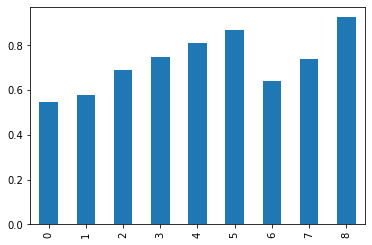

In [196]:
df_lr = pd.DataFrame(report_lr).transpose()
df_lr[:-3]["f1-score"].plot.bar()

### Q1c:
Choose your own classifier/tokenization/normalisations approach, and report on its performance with respect to the five previous ones on the test set.
You should describe your selected classifier and vectorization approach including a justification for its appropriateness.

In [197]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(tfidf_vec_train.toarray(), Y_train)
preds = sgd.predict(tfidf_vec_test.toarray())
print(classification_report(Y_test, preds))

classifier_scores = classifier_scores.append({'classifier' : 'SGDClassifier',
                          'accuracy' : accuracy_score(Y_test, preds),
                          'precision' : precision_score(Y_test, preds, average='weighted'),
                          'recall' : recall_score(Y_test, preds, average='weighted'),
                          'f1_score' : f1_score(Y_test, preds, average='weighted')}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.67      0.54      0.60        48
           1       0.57      0.55      0.56        47
           2       0.75      0.81      0.78        52
           3       0.94      0.73      0.82        44
           4       0.71      0.92      0.80        38
           5       0.86      0.88      0.87        56
           6       0.67      0.70      0.69        44
           7       0.85      0.76      0.80        29
           8       0.81      0.90      0.85        42

    accuracy                           0.75       400
   macro avg       0.76      0.75      0.75       400
weighted avg       0.76      0.75      0.75       400



Function that returns the best performing model

In [198]:
classifier_scores.style.apply(highlight_max, threshold=classifier_scores['f1_score'].max(), column=['f1_score'], axis=1)

,classifier,accuracy,precision,recall,f1_score
0,Dummy_classifier_Most_frequent,0.105000,0.011025,0.105000,0.019955
1,Dummy_classifier_stratified,0.130000,0.126524,0.130000,0.126329
2,LogisticRegression - One Hot Vector,0.737500,0.748216,0.737500,0.739054
3,LogisticRegression - TFIDF,0.725000,0.730800,0.725000,0.725273
4,SVC(rbf),0.627500,0.713063,0.627500,0.643214
5,SGDClassifier,0.752500,0.756021,0.752500,0.750084


## Q2: Tuning and Error Analysis

In this task you will improve the effectiveness of the LogisticRegression with TF-IDF vectorization from Q1. 

### Q2a:

**Parameter** tuning - Tune the parameters for both the vectorizer and classifier on the validation set (or using CV-fold validation on the train).

* Classifier - Regularisation C value (typical values might be powers of 10 (from 10^-3 to 10^5)
* Vectorizer - Parameters: sublinear_tf and max_features (vocabulary size) (in a range None to 50k)
*  Select another parameter of your choice from the classifier or vectorizer

In [199]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[('tfidf', TfidfVectorizer()), ('lr', LogisticRegression(max_iter = 1000))])

 

param_grid = {
    'tfidf__sublinear_tf': [True, False],
    'tfidf__max_features': [None, 500, 5000, 50000],
    'lr__C': [0.01, 0.1, 100, 1000, 10000],
    'lr__class_weight': [None, 'balanced'],
    'tfidf__ngram_range': [(1,1), (1,2)]
}

search = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=3)
search.fit(X_train_tokenized, Y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 3 folds for each of 160 candidates, totalling 480 fits
Best parameter (CV score=0.765):
{'lr__C': 100, 'lr__class_weight': 'balanced', 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True}


In [200]:
tfidf_transformer = TfidfVectorizer(max_features=None, ngram_range=(1,2), sublinear_tf=True)
tfidf_transformer.fit(X_train_tokenized)

X_train_tfidf = tfidf_transformer.transform(X_train_tokenized)

lr_model = LogisticRegression(C=100, class_weight='balanced', max_iter=1000)
lr_model.fit(X_train_tfidf, Y_train)

LogisticRegression(C=100, class_weight='balanced', max_iter=1000)

### Q2b:

Error analysis - Manually examine the predictions of your optimised classifier on the test set.  Analyse the results for patterns and trends.  Hypothesise why common classification errors are made.  Report on your error analysis process and summarise your findings. 

In [201]:
X_test_transformed = tfidf_transformer.transform(X_test)

preds = lr_model.predict(X_test_transformed)
print(classification_report(Y_test, preds))


              precision    recall  f1-score   support

           0       0.37      0.79      0.50        48
           1       0.71      0.36      0.48        47
           2       0.83      0.65      0.73        52
           3       0.86      0.73      0.79        44
           4       0.94      0.84      0.89        38
           5       0.91      0.89      0.90        56
           6       0.86      0.68      0.76        44
           7       0.83      0.86      0.85        29
           8       0.93      0.88      0.90        42

    accuracy                           0.74       400
   macro avg       0.80      0.74      0.76       400
weighted avg       0.80      0.74      0.75       400



## Q3: Feature Engineering 

In this task your goal is to add two features to (try to) improve subreddit classification performance obtained in Q2.
You must implement and describe two new classifier features and add them to the tuned model from Q2. Examples include adding other properties of the posts, leveraging embedding-based features, different vectorization approaches, etc, (This is your chance to be creative!). As before, report the results in terms of evaluation metrics on the test data. Additionally, include a well-labelled confusion matrix and discuss the result in reference to Q2 and what helped (or didn’t) and why you think so. In summary: 


### Q3a:
Propose two features of your own, along with your rationale behind your choice. 

In [202]:
train_data['post_length'] = [len(x) for x in train_data['body']]
test_data['post_length'] = [len(x) for x in test_data['body']]
validation_data['post_length'] = [len(x) for x in validation_data['body']]

In [203]:
train_data.head()

,subreddit,title,score,id,author,body,labels,post_length
0,PS4,Can I get banned for having a game that I didn...,0,queqfu,XC-XERZ,"Long story short, I saw ESO in my library, dow...",0,161
1,pcgaming,How to get a Kinect sensor to work with a PC?,0,1eujoa,ZachTheKing,I have seen a video online where someone took ...,1,242
2,NintendoSwitch,Switch Only Charges with GoPro Cable,5,m00bx7,BluePenguin2002,"Hi, hope this is the right place/way to post t...",2,727
3,antiMLM,L’Occitane going down MLM route?,15,q13pvx,100fluffyclouds,After buying a majority share in Limelight/Alc...,3,131
4,HydroHomies,Guys i need your help,2,rxiv2g,Epicskeleton53,Is it ok for me to drink coffee in the morning...,4,100


In [204]:
X_train_combined = [ text_pipeline_spacy(x) for x in train_data['body'] + ' ' +train_data['title'] ]
X_test_combined = [ text_pipeline_spacy(x) for x in test_data['body'] + ' ' +test_data['title'] ]
X_validation_combined = [ text_pipeline_spacy(x) for x in validation_data['body'] + ' ' +validation_data['title'] ]

### Q3b:
Train, validate and test models that incorporate combinations of your features, and briefly report on the evaluation metrics 

In [205]:
tfidf_transformer_final = TfidfVectorizer(max_features=None, ngram_range=(1,2), sublinear_tf=True)
tfidf_transformer_final.fit(X_train_combined)

X_train_combined = tfidf_transformer_final.transform(X_train_combined)
X_test_combined = tfidf_transformer_final.transform(X_test_combined)
X_validation_combined = tfidf_transformer_final.transform(X_validation_combined)

X_train_combined.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [206]:
import numpy as np
from scipy import sparse
from sklearn.preprocessing import normalize

XTRAIN = np.append( X_train_combined.toarray(), np.array(train_data['post_length']).reshape(-1,1),axis=1)
XTEST = np.append( X_test_combined.toarray(), np.array(test_data['post_length']).reshape(-1,1),axis=1)
XVALIDATION = np.append( X_validation_combined.toarray(), np.array(validation_data['post_length']).reshape(-1,1),axis=1)



XTRAIN = sparse.csr_matrix(XTRAIN)


XTRAIN.shape


(1200, 45884)

In [207]:
lr_model = LogisticRegression(C=100, class_weight='balanced', max_iter=1000)
lr_model.fit(XTRAIN, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=100, class_weight='balanced', max_iter=1000)

In [208]:
preds = lr_model.predict(XTEST)

In [209]:
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75        48
           1       0.69      0.66      0.67        47
           2       0.86      0.83      0.84        52
           3       0.84      0.86      0.85        44
           4       0.89      0.87      0.88        38
           5       0.98      0.93      0.95        56
           6       0.85      0.89      0.87        44
           7       0.87      0.93      0.90        29
           8       0.95      0.95      0.95        42

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



### Q3c:
Provide performance analysis (intrinsic evaluation metrics) of the model with your proposed features, and discuss   (In your opinion), why did it work / or didn’t work / what could be done to improve (Try to connect it to the lecture material) 